In [1]:
import cartopy
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [2]:
# Atlantic sector of the real world
Atlantic_longitudes = -100, 22
Atlantic_latitudes = -84, 80

# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 80
NW2_latS, NW2_latN = -70, 70

Atlantic_lon_offset = -84 # For overlaying NeverWorld2 domain on the real Atlantic (or vice versa)

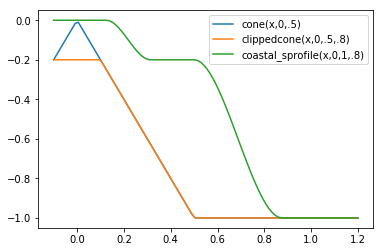

In [3]:
class topo:
    def __init__(self, nj, ni, dlon=1, dlat=1, lon0=0, lat0=0, D=1):
        """
        Create a topo object with a mesh of nj*ni cells with depth -D
        on a mesg ranging from lon0..lon0+dlon and lat0..lat0+dlat.
        
        By default D=1, dlon=1, dlat=1, lon0=0 and lat0=0.
        """
        self.z = -D * numpy.ones((nj,ni))
        self.D0 = D # Nominal deepest depth
        # Coordinates of grid nodes (0..1)
        self.xg = numpy.arange(ni+1)/ni * dlon + lon0
        self.yg = numpy.arange(nj+1)/nj * dlat + lat0
        # Coordinates of cell centers (0..1)
        self.xc = (numpy.arange(ni)+0.5)/ni * dlon + lon0
        self.yc = (numpy.arange(nj)+0.5)/nj * dlat + lat0
        # Store 2D arrays of coordinates
        self.XG, self.YG = numpy.meshgrid(self.xg, self.yg)
        self.XC, self.YC = numpy.meshgrid(self.xc, self.yc)
    # Some 1D functions to generate simple shapes
    def heaviside(x, x0):
        b = 0*x
        b[x>=x0] = 1
        return b
    def box(x, x0, x1):
        return topo.heaviside(x, x0) * topo.heaviside(-x, -x1)
    def cone(x, x0, dx):
        return numpy.maximum(0, 1. - numpy.abs(x-x0)/dx) - 1
    def clipped_cone(x, x0, dx, clip):
        return numpy.minimum(clip-1, topo.cone(x, x0, dx))
    def scurve(x, x0, dx):
        s = numpy.minimum(1, numpy.maximum(0, (x-x0)/dx))
        return (3 - 2*s)*( s*s )
    # Actual coastal profile
    def coastal_sprofile(x, x0, dx, shelf, cf=0.25, sf=.5, res=.125):
        s = ( x - x0 )/dx
        s = ( s - res )/( 1 - 2*res )
        return ( 0 - ( (1-shelf)*topo.scurve(s, 0, cf) + shelf*topo.scurve(s, sf, (1-sf) ) ) )
    def test1d():
        x = numpy.linspace(-.1,1.2,100)
#         plt.plot(x, -topo.box(x,-.25,.5), label='-box(x,-0.25,.5)')
        plt.plot(x, topo.cone(x,0,.5), label='cone(x,0,.5)')
        plt.plot(x, topo.clipped_cone(x,0,.5,.8), label='clippedcone(x,0,.5,.8)')
#         plt.plot(x, 1-topo.scurve(x,0,1), label='1-scurve(x,0,1)')
        plt.plot(x, topo.coastal_sprofile(x,0,1,.8), label='coastal_sprofile(x,0,1,.8)')
        plt.legend()
    def dist_from_line(X,x0,Y,y0,y1):
        dx = X - x0
        yr = numpy.minimum( numpy.maximum(Y, y0), y1)
        dy = Y - yr
        return numpy.sqrt( dx*dx + dy*dy)
    def add_NS_ridge(self, lon, lat0, lat1, dlon, dH, clip=0, p=1):
        r_fn = topo.cone(topo.dist_from_line(self.XC, lon, self.YC, lat0, lat1), 0, dlon)**p
        self.z = numpy.maximum(self.z, numpy.minimum(clip, (self.D0 - dH) * r_fn - dH))
    def add_NS_coast(self, lon, lat0, lat1, dlon, shelf):
        r = topo.dist_from_line(self.XC, lon, self.YC, lat0, lat1)
        self.z = numpy.maximum(self.z, self.D0 * topo.coastal_sprofile(r, 0, dlon, 1-shelf/self.D0) )
    def add_EW_ridge(self, lon0, lon1, lat, dlat, dH, clip=0, p=1):
        r_fn = topo.cone(topo.dist_from_line(self.YC, lat, self.XC, lon0, lon1), 0, dlat)**p
        self.z = numpy.maximum(self.z, numpy.minimum(clip, dH * r_fn - self.D0))
    def add_EW_coast(self, lon0, lon1, lat, dlat, shelf):
        r = topo.dist_from_line(self.YC, lat, self.XC, lon0, lon1)
        self.z = numpy.maximum(self.z, self.D0 * topo.coastal_sprofile(r, 0, dlat, 1-shelf/self.D0) )
    def add_angled_coast(self, lon_eq, lat_mer, dr, shelf):
        A, B, C = lat_mer, lon_eq, -lon_eq * lat_mer
        r = 1. / numpy.sqrt( A*A + B*B )
        r = r * ( A * self.XC + B * self.YC + C )
        r_fn = topo.coastal_sprofile(r, 0, dr, 1-shelf/self.D0)
        self.z = numpy.maximum(self.z, self.D0 * r_fn )
    def add_land(self, lon_eq, lat_mer, dr, dH, clip=0, p=1, coast_frac=0.5):
        self.add_land_slope(lon_eq, lat_mer, dr*coast_frac, dH, p=p)
        self.add_land_slope(lon_eq, lat_mer, dr, dH, clip=clip, p=p)
    def add_circular_ridge(self, lon0, lat0, radius, dr, dH, clip=0):
        r = numpy.sqrt( (self.XC - lon0)**2 + (self.YC - lat0)**2 )
        r = numpy.abs( r - radius)
        r_fn = topo.clipped_cone(r, 0, dr, dH/self.D0)
        self.z = numpy.maximum(self.z, numpy.minimum(clip, self.D0 * r_fn ))
topo.test1d()

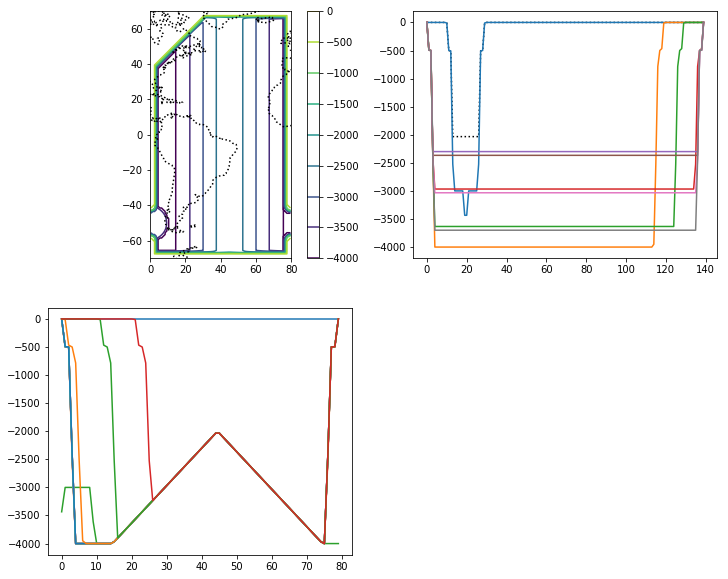

In [4]:
D0 = 4000
p = 1
cw, cd = 5, 500
T = topo(140, 80, dlon=80, dlat=140, lat0=-70, D=D0)
T.add_NS_coast(0, -40, 90, cw, cd)
T.add_NS_coast(80, -40, 90, cw, cd)
T.add_NS_coast(0, -90, -60, cw, cd)
T.add_NS_coast(80, -90, -60, cw, cd)
T.add_EW_coast(-360, 360, -70, cw, cd)
T.add_EW_coast(-360, 360, 70, cw, cd)
T.add_angled_coast(-40, 40, cw, cd)
T.add_circular_ridge(0, -50, 5, 5, 1000)
T.add_NS_ridge(45, -90, 90, 30, D0/2)
# T.add_circular_ridge(20, 30, 0, 5, 3000) # Seamount?

plt.figure(figsize=(12,10))
ax = plt.subplot(2,2,1)
plt.contour(T.xc, T.yc, T.z, levels=numpy.arange(-D0,1,500))
plt.colorbar()

# Draw coastlines in NeverWorld2 space (i.e. offset in longitude)
for geo in cartopy.feature.COASTLINE.geometries():
    for g in geo:
        x,y = zip(*list(g.coords))
        plt.plot(numpy.array(x)-Atlantic_lon_offset,y, 'k:')
ax.set_xlim(NW2_lonW, NW2_lonE)
ax.set_ylim(NW2_latS, NW2_latN)
ax.set_aspect('equal')

plt.subplot(2,2,2)
plt.plot( T.z.max(axis=1), 'k:')
plt.plot( T.z[:,::10]);
plt.subplot(2,2,3)
plt.plot( T.z[::10,:].T);